# Face Generation using DCGAN


In this notebook a simple deep convolutioal gan is implemented


## Table Of Content

1. [Setup](#setup)
   1. [Set Parameter](#set-parameter)
   2. [Helper Functions](#helper-functions)
2. [Prepare Data](#prepare-data)
3. [Initialize GAN](#initialize-generator-and-discrimintor)
4. [Train GAN](#train-model)
5. [Evaluate](#evaluate)


## Imports


In [4]:
import os
import shutil
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_fid import fid_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from tqdm import tqdm

warnings.simplefilter("ignore")

## Setup


In [2]:
# to use gpu acceleration on mac uncomment the following line
device = torch.device(
    "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)
# to use gpu acceleration on windows uncomment the following line
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# set random seed for reproducibility
np.random.seed(42)

mps


### Set Parameter


In [7]:
# model hyperparameters
learning_rate = 2e-4
batch_size = 128
img_size = 64
channels = 3
z_dim = 100
epochs = 10

# data parameters
val_set_size = 0.3

### Variables


In [6]:
DATA_PATH = "./data/"
TRAIN_DATA = f"{DATA_PATH}/celebs/"
GENERATED_DATA = f"{DATA_PATH}/generated/"

### Helper Functions


In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels: int, features: int) -> None:
        """create a discriminator model

        Args:
            img_channels (int): number of input channels of the image (3 for RGB, 1 for grayscale)
            features (int): number of features in the first convolutional layer (multiplied by 2 in each subsequent layer, usually related to image size)
        """
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            self.conv_block(img_channels, features, kernel_size=4, stride=2, padding=1),
            self.conv_block(features, features * 2, kernel_size=4, stride=2, padding=1),
            self.conv_block(
                features * 2, features * 4, kernel_size=4, stride=2, padding=1
            ),
            self.conv_block(
                features * 4, features * 8, kernel_size=4, stride=2, padding=1
            ),
            nn.Conv2d(features * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

    def conv_block(
        self,
        in_channles: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
    ) -> nn.Sequential:
        """create a convolutional block with batch normalization and leaky relu activation

        Args:
            in_channles (int): number of input channels
            out_channels (int): number of output channels
            kernel_size (int, optional): kernel window size. Defaults to 4.
            stride (int, optional): size of striding window. Defaults to 2.
            padding (int, optional): size of padding window. Defaults to 1.

        Returns:
            nn.Sequential: a sequential block of convolutional layer, batch normalization and leaky relu activation
        """
        layer = [
            nn.Conv2d(
                in_channles,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(0.2),
        ]
        return nn.Sequential(*layer)

    def init_weights(self) -> None:
        """initialize weights of the model"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)


class Generator(nn.Module):
    def __init__(self, z_dim: int, img_channels: int, features: int) -> None:
        """create a generator model

        Args:
            z_dim (int): dimension of the input noise vector
            img_channels (int): number of output channels of the image (3 for RGB, 1 for grayscale)
            features (int): number of features in the first convolutional layer (multiplied by 2 in each subsequent layer, usually related to image size)
        """
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            self.trans_conv_block(
                z_dim, features * 16, kernel_size=4, stride=1, padding=0
            ),
            self.trans_conv_block(
                features * 16, features * 8, kernel_size=4, stride=2, padding=1
            ),
            self.trans_conv_block(
                features * 8, features * 4, kernel_size=4, stride=2, padding=1
            ),
            self.trans_conv_block(
                features * 4, features * 2, kernel_size=4, stride=2, padding=1
            ),
            nn.ConvTranspose2d(
                features * 2, img_channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x) -> torch.Tensor:
        """function to forwad pass through the model"""
        return self.main(x)

    def trans_conv_block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
    ) -> nn.Sequential:
        """creating a transposed convolutional block consisting of convolutional layer, batch normalization, relu activation and dropout layer

        Args:
            in_channels (int): input channels
            out_channels (int): output channels
            kernel_size (int, optional): kernel window size. Defaults to 4.
            stride (int, optional): size of striding window. Defaults to 2.
            padding (int, optional): size of padding window. Defaults to 1.

        Returns:
            nn.Sequential: a sequential block of transposed convolutional layer, batch normalization, relu activation and dropout layer
        """
        layer = [
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout(0.25),
        ]
        return nn.Sequential(*layer)

    def init_weights(self) -> None:
        """initialize weights of the model"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

## Prepare Data


In [6]:
# create trainsformer for the images with some data augmentation
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
# load images
data = ImageFolder(root=TRAIN_DATA, transform=transform)
idx = np.random.permutation(len(data))

# split data into train and validation
split = int(np.floor(val_set_size * len(data)))
train_idx, val_idx = idx[split:], idx[:split]

# create train data loaders
train_sampler = SubsetRandomSampler(train_idx)
dl = DataLoader(data, batch_size=batch_size, sampler=train_sampler)

# create validation data loaders
val_sampler = SubsetRandomSampler(val_idx)
val_dl = DataLoader(data, batch_size=batch_size, sampler=val_sampler)

In [7]:
img = data[0]
img[0].shape

torch.Size([3, 64, 64])

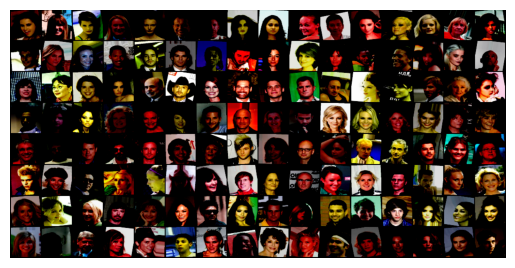

In [8]:
# select random batch of images to display
for images, _ in dl:
    images = images.reshape(images.size(0), channels, img_size, img_size)
    torchvision.utils.save_image(
        images, os.path.join(DATA_PATH, "example_real_images.png"), nrow=16
    )
    break

# display image
img = Image.open(os.path.join(DATA_PATH, "example_real_images.png"))
plt.imshow(img)
plt.axis("off")
plt.show()

## Initialize Generator and Discrimintor


In [9]:
gen = Generator(z_dim=z_dim, img_channels=channels, features=img_size).to(device)
gen.init_weights()

disc = Discriminator(img_channels=channels, features=img_size).to(device)
disc.init_weights()

In [10]:
# create optimizer and learning rate scheduler
lr_step_size = 10
lr_gamma = 0.1

g_optimizer = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
scheduler_g = StepLR(g_optimizer, step_size=lr_step_size, gamma=lr_gamma)

d_optimizer = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
scheduler_d = StepLR(d_optimizer, step_size=lr_step_size, gamma=lr_gamma)

# initialize BCE as loss function
loss = nn.BCELoss()

## Train Model


In [11]:
losses_disc = list()
losses_gen = list()

for epoch in range(epochs):

    for image, _ in tqdm(dl, total=len(dl)):
        batch = image.size(0)
        image = image.to(device)

        # train discriminator
        noise = torch.randn(batch, z_dim, 1, 1).to(device)
        fake_image = gen(noise)
        disc_real = disc(image).reshape(-1)
        disc_fake = disc(fake_image.detach()).reshape(-1)

        # calculate losses
        loss_disc_real = loss(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = (loss_disc_real + loss_disc_fake) / 2

        # perform backpropagation and optimization
        disc.zero_grad()
        disc_loss.backward()
        d_optimizer.step()

        # train generator
        output = disc(fake_image).reshape(-1)
        g_loss = loss(output, torch.ones_like(output))

        gen.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # save losses to list
        losses_disc.append(disc_loss.item())
        losses_gen.append(g_loss.item())

    # adapt learning rate
    scheduler_g.step()
    scheduler_d.step()

    # evaluate model during trainings by generating images
    with torch.no_grad():
        gen.eval()
        noise = torch.randn(batch, z_dim, 1, 1).to(device)
        fake_image = gen(noise)
        save_image(
            fake_image,
            os.path.join(DATA_PATH, "generated", f"gen_images_{epoch+1}.png"),
            nrow=16,
        ),
        gen.train()

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {disc_loss:.4f}, Loss G: {g_loss:.4f}")

100%|██████████| 1108/1108 [12:30<00:00,  1.48it/s]


Epoch [1/10] Loss D: 0.4666, Loss G: 0.8432


100%|██████████| 1108/1108 [12:19<00:00,  1.50it/s]


Epoch [2/10] Loss D: 0.3467, Loss G: 1.9539


100%|██████████| 1108/1108 [12:21<00:00,  1.49it/s]


Epoch [3/10] Loss D: 0.3001, Loss G: 2.3856


100%|██████████| 1108/1108 [12:12<00:00,  1.51it/s]


Epoch [4/10] Loss D: 0.2172, Loss G: 2.6526


100%|██████████| 1108/1108 [12:12<00:00,  1.51it/s]


Epoch [5/10] Loss D: 0.1568, Loss G: 3.1242


100%|██████████| 1108/1108 [12:11<00:00,  1.52it/s]


Epoch [6/10] Loss D: 0.1845, Loss G: 3.8523


100%|██████████| 1108/1108 [12:10<00:00,  1.52it/s]


Epoch [7/10] Loss D: 1.0521, Loss G: 7.9130


100%|██████████| 1108/1108 [12:24<00:00,  1.49it/s]


Epoch [8/10] Loss D: 0.3814, Loss G: 1.4709


100%|██████████| 1108/1108 [12:15<00:00,  1.51it/s]


Epoch [9/10] Loss D: 0.0443, Loss G: 3.5913


100%|██████████| 1108/1108 [12:26<00:00,  1.49it/s]


Epoch [10/10] Loss D: 0.0046, Loss G: 6.7001


## Evaluate


### Plot Losses


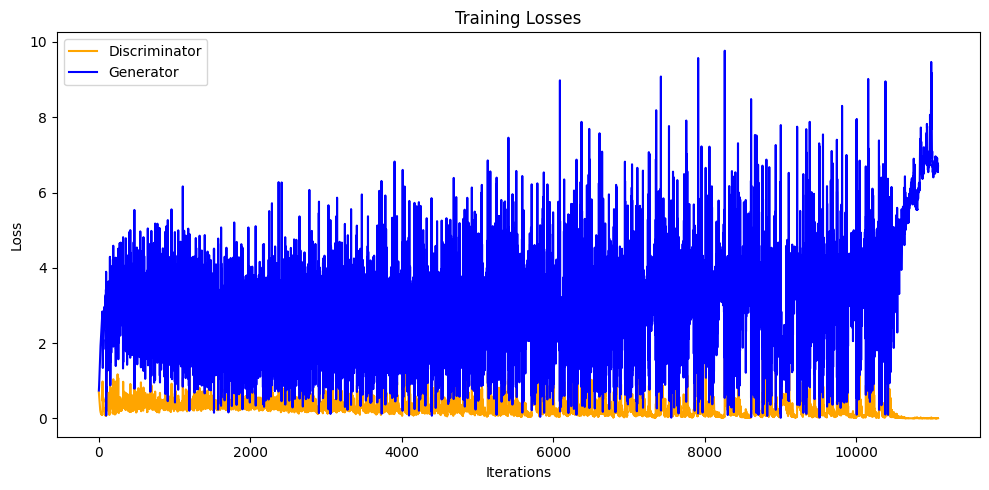

In [12]:
fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(losses_disc, label="Discriminator", color="orange")
axes.plot(losses_gen, label="Generator", color="blue")

axes.set_xlabel("Iterations")
axes.set_ylabel("Loss")

axes.set_title("Training Losses")

axes.legend()

fig.tight_layout()

### Evaluate based on FID


In [13]:
# load pretrained inception model to evaluate gan
inception = torch.hub.load("pytorch/vision:v0.9.0", "inception_v3", pretrained=True)
inception.eval()

# set generator to evaluation mode
gen.eval()

Using cache found in /Users/lwaetzig/.cache/torch/hub/pytorch_vision_v0.9.0


Generator(
  (main): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [14]:
generated_images = list()
# generate images
for i in tqdm(range(1000 // batch_size)):
    with torch.no_grad():
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_image = gen(noise)
        generated_images.append(fake_image)

# concatenate images into single tensor
generated_images = torch.cat(generated_images, dim=0)

100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


In [15]:
# create list of validation images
real_images = list()
for image, _ in tqdm(val_dl, total=len(val_dl)):
    real_images.append(image)

# concatenate images into single tensor
real_images = torch.cat(real_images, dim=0)

100%|██████████| 475/475 [01:55<00:00,  4.13it/s]


In [16]:
# create temporary directories to store images (its necessary for fid_score function)
temp_dir_real = tempfile.mkdtemp()
temp_dir_generated = tempfile.mkdtemp()

# store images in temporary directories
for i, images in enumerate([real_images, generated_images]):
    for j, image in enumerate(images):
        save_image(
            image,
            os.path.join(temp_dir_real if i == 0 else temp_dir_generated, f"{j}.png"),
        )

# calculate FID score
fid = fid_score.calculate_fid_given_paths(
    paths=[temp_dir_real, temp_dir_generated],
    batch_size=batch_size,
    device="mps",
    dims=2048,
)
print(f"FID: {fid}")

# remove temporary directories and files
shutil.rmtree(temp_dir_real)
shutil.rmtree(temp_dir_generated)

100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


FID: 384.81929791587606


### Generate example image


(-0.5, 1057.5, 3697.5, -0.5)

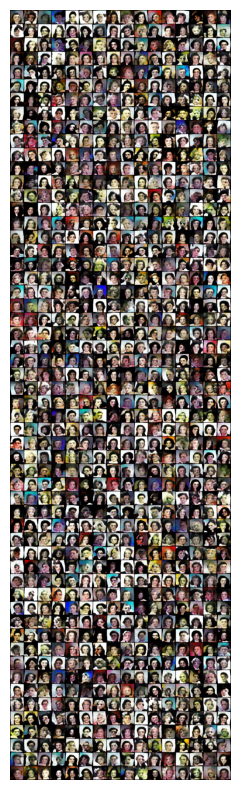

In [12]:
# create example images
noise = torch.randn(16, z_dim, 1, 1).to(device)
fake_image = gen(noise)
save_image(
    fake_image,
    os.path.join(DATA_PATH, "example_generated_images.png"),
    nrow=16,
)
# display image
img = Image.open(os.path.join(DATA_PATH, "example_generated_images.png"))
fig, axes = plt.subplots(figsize=(5, 10))
axes.imshow(img)
axes.axis("off")